In [1]:
from pyrpl import Pyrpl
from pyrpl.async_utils import sleep

import numpy as np
from scipy.signal import find_peaks

import matplotlib.pyplot as plt

In [2]:
p = Pyrpl(config="scanning-cavity-lock")
r = p.rp

INFO:pyrpl:All your PyRPL settings will be saved to the config file
    C:\Users\ThompsonLab\pyrpl_user_dir\config\scanning-cavity-lock.yml
If you would like to restart PyRPL with these settings, type "pyrpl.exe scanning-cavity-lock" in a windows terminal or 
    from pyrpl import Pyrpl
    p = Pyrpl('scanning-cavity-lock')
in a python terminal.
INFO:pyrpl.redpitaya:Successfully connected to Redpitaya with hostname 10.0.5.12.


In [3]:
DRIVE_FREQUENCY = 1e3

# `scipy.signal.find_peaks`

In [4]:
r.scope.input1 = 'asg0'
r.scope.input2 = 'in1'

r.scope.trigger_source = 'ch1_positive_edge'
r.scope.trigger_delay = 0
r.scope.threshold = 0.1
r.scope.hysteresis = 0.01

r.scope.duration = 2/DRIVE_FREQUENCY
r.scope.trace_average = 1000

INFO:pyrpl.modules:Calling setup() for scope.trigger_source ...


In [14]:
trace = r.scope.curve_async()

r.asg0.setup(frequency=DRIVE_FREQUENCY, amplitude=0.5, offset=0.5, waveform='sin', trigger_source='immediately', output_direct='out1')
sleep(0.01)

drive_trace, cavity_trace = trace.result()

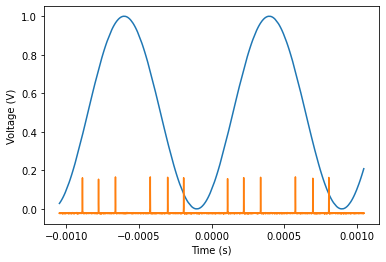

In [15]:
plt.plot(r.scope.times, drive_trace)
plt.plot(r.scope.times, cavity_trace)

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")

plt.show()

In [16]:
drive_troughs, _ = find_peaks(1 - drive_trace)
print(f"Drive Troughs: {drive_troughs}")

drive_center, _ = find_peaks(drive_trace[drive_troughs[0]:drive_troughs[1]])
drive_center = drive_troughs[0] + drive_center[0]
print(f"Drive Center: {drive_center}")

cavity_peaks, _ = find_peaks(cavity_trace[drive_troughs[0]:drive_troughs[1]], height=0.1)
cavity_peaks = drive_troughs[0] + cavity_peaks
print(f"Cavity Peaks: {cavity_peaks}")

cavity_center = np.rint(np.mean(cavity_peaks)).astype(int)
print(f"Cavity Center: {cavity_center}")

center_difference = r.scope.times[cavity_center] - r.scope.times[drive_center]
phase_shift = 360 * DRIVE_FREQUENCY * center_difference

print(f"Phase Shift: {phase_shift}°")

Drive Troughs: [ 7391 15203]
Drive Center: 11297
Cavity Peaks: [ 9052  9919 10830 12703 13639 14500]
Cavity Center: 11774
Phase Shift: 21.98016000000003°


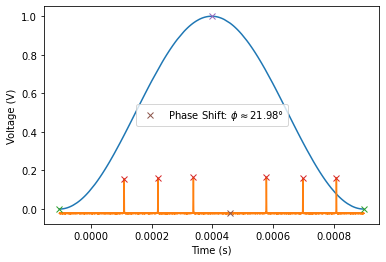

In [17]:
plt.plot(r.scope.times[drive_troughs[0]:drive_troughs[1]], drive_trace[drive_troughs[0]:drive_troughs[1]])
plt.plot(r.scope.times[drive_troughs[0]:drive_troughs[1]], cavity_trace[drive_troughs[0]:drive_troughs[1]])

plt.plot(r.scope.times[drive_troughs], drive_trace[drive_troughs], 'x')
plt.plot(r.scope.times[cavity_peaks], cavity_trace[cavity_peaks], 'x')

plt.plot(r.scope.times[drive_center], drive_trace[drive_center], 'x')
plt.plot(r.scope.times[cavity_center], cavity_trace[cavity_center], 'x', label=f"Phase Shift: $\\phi\\approx{phase_shift:.2f}$°")

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.legend()

plt.show()